1. Temat projektu

Wyznaczanie minimalnego okręgu i prostokąta zawierającego chmurę punktów na płaszczyźnie

Reference: https://prezi.com/ehey3lpea0dy/wyznaczanie-minimalnego-okregu-i-prostokata-zawierajacego-ch/

2. Potrzebne biblioteki

In [3]:
import copy
import functools
import random
import math
from collections import deque
from bitalg.visualizer.main import Visualizer

3. Testowe zbiory punktów

3.1. Funkcje generujące punkty na płaszczyźnie

In [4]:
def generate_uniform_points(left=-100, right=100, n=100):

    T = []

    for i in range( n ):

        T.append((random.uniform(left, right), random.uniform(left, right)))
        
    return T

In [5]:
def generate_circle_points(O, R, n=100):
    
    T = []
    
    for i in range(n):

        f = random.uniform(0, 2) * math.pi

        x = R * math.cos(f) - O[0]
        y = R * math.sin(f) - O[1]

        T.append((x,y))
        
    return T

In [6]:
def generate_rectangle_points(a=(-10, -10), b=(10, -10), c=(10, 10), d=(-10, 10), n=100):

    T = []

    v1 = (a[0] - b[0], a[1] - b[1])
    v2 = (b[0] - c[0], b[1] - c[1])
    v3 = (c[0] - d[0], c[1] - d[1])
    v4 = (d[0] - a[0], d[1] - a[1])

    for i in range(n):
        x = random.randint(1, 4)
        y = random.random()

        if x ==1:
            T.append( (b[0] + v1[0] * y, b[1] + v1[1] * y) )
        elif x == 2:
            T.append( (c[0] + v2[0] * y, c[1] + v2[1] * y) )
        elif x == 3:
            T.append( (d[0] + v3[0] * y, d[1] + v3[1] * y) )
        else:
            T.append( (a[0] + v4[0] * y, a[1] + v4[1] * y) )
        
        
        #T.append((c, (a[1] - b[1]) / (a[0] - b[0]) * c + ( a[1] - ((a[1] - b[1]) / (a[0] - b[0])) * a[0] )))
    
    return T

In [7]:
def generate_square_points(a=(0, 0), b=(10, 0), c=(10, 10), d=(0, 10), axis_n=25, diag_n=20):

    T = []

    v1 = (a[0] - b[0], a[1] - b[1])
    v2 = (d[0] - a[0], d[1] - a[1])

    for i in range(axis_n):
        
        y = random.random()
        
        T.append( (b[0] + v1[0] * y, b[1] + v1[1] * y) )
        
    for i in range(axis_n):

        y = random.random()
    
        T.append( (a[0] + v2[0] * y, a[1] + v2[1] * y) )

    d1 = (b[0] - d[0], b[1] - d[1])
    d2 = (a[0] - c[0], a[1] - c[1])
    
    for i in range(diag_n):

        y = random.random()

        T.append( (d[0] + d1[0] * y, d[1] + d1[1] * y) )

    for i in range(diag_n):

        y = random.random()

        T.append( (c[0] + d2[0] * y, c[1] + d2[1] * y) )

    T.append( a )
    T.append( b )
    T.append( c )
    T.append( d )

    
    return T

3.2. Wygenerowane zbiory punktów

In [8]:
points_a = generate_uniform_points(-100, 100, 100)

In [9]:
points_aa = generate_uniform_points(-100, 100, 4)

In [10]:
points_b = generate_circle_points((0, 0), 10, 100)

In [11]:
points_c = generate_rectangle_points((-10, -10), (10, -10), (10, 10), (-10, 10), 100)

In [12]:
points_d = generate_square_points((0, 0), (10, 0), (10, 10), (0, 10), 25, 20)

3.3. Wizualizacja wygenerowanych zbiorów

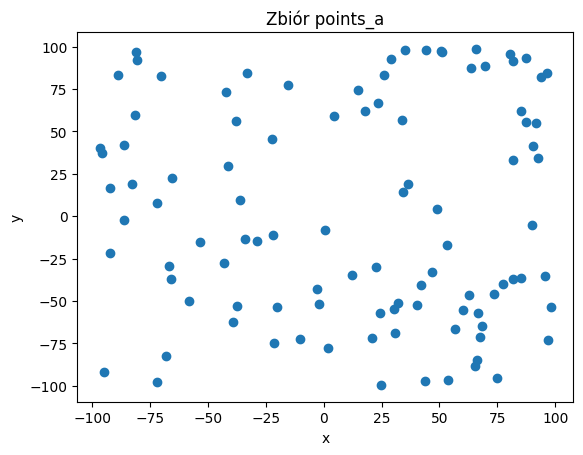

In [13]:
vis = Visualizer()
vis.add_title('Zbiór points_a')
vis.add_point(points_a)
vis.show()

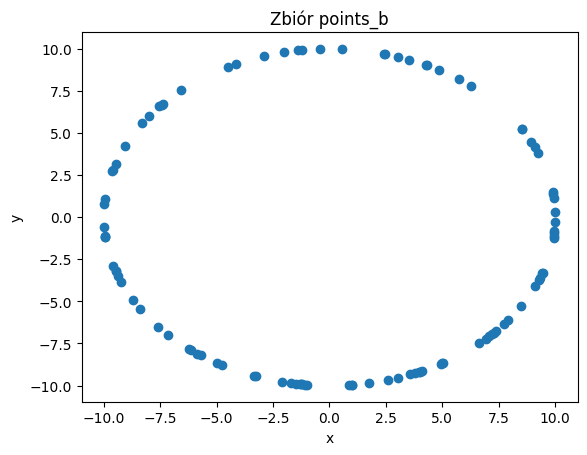

In [14]:
vis = Visualizer()
vis.add_title('Zbiór points_b')
vis.add_point(points_b)
vis.show()

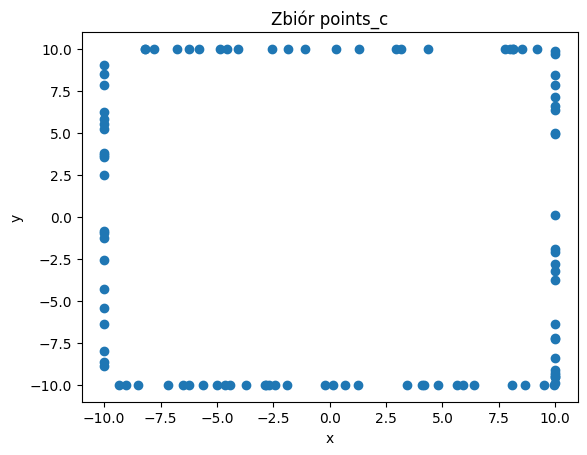

In [15]:
vis = Visualizer()
vis.add_title('Zbiór points_c')
vis.add_point(points_c)
vis.show()

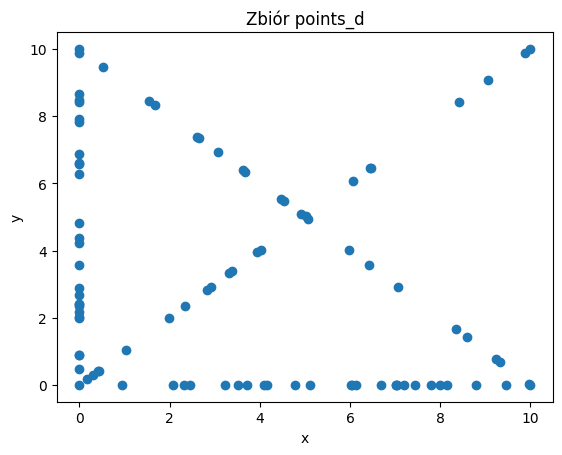

In [16]:
vis = Visualizer()
vis.add_title('Zbiór points_d')
vis.add_point(points_d)
vis.show()

4. Algorytm Grahama - zaimplementowany na zajęciach

In [17]:
def det(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

def distance(P, A, B):
    
    #Wektor PA
    PA = (A[0] - P[0], A[1] - P[1])

    #Moduł wektora PA
    PA_mod = (PA[0] ** 2 + PA[1] ** 2)**(0.5)   

    #Wektor PB
    PB = (B[0] - P[0], B[1] - P[1])

    #Moduł wektora PB
    PB_mod = (PB[0] ** 2 + PB[1] ** 2)**(0.5)

    if PA_mod > PB_mod:
        return 1
    else:
        return -1

def cmp(P, A, B, eps = 0):
    
    # -1 - B jest po lewej od PA
    # 1 - B jest po prawej od PA
    # 0 - B jest na PA

    calculatedOrientation = orient(P, A, B)
    
    if calculatedOrientation != 0:
        return calculatedOrientation
    else:
        return distance(P, A, B)

def orient(P, A, B, eps = 0):
    
    # -1 - B jest po lewej od PA
    # 1 - B jest po prawej od PA
    # 0 - B jest na PA
    
    res = det(P, A, B)
    
    if res < -eps: #B leży po prawej stronie od PA
        return 1
    elif res > eps: #B leży po lewej stronie od PA
        return -1
    else:
        return 0

def graham_algorithm(X):

    #Zbiór pusty
    if len(X) == 0:
        return []
    
    #Kopiuję tablicę, żeby nie zniszczyć oryginalnej, która potem jest używana do wyświetlania
    Q = copy.deepcopy(X) 

    #Punkt początkowy o najmiejszej współrzędnej y oraz x
    P = min(Q, key = lambda l: (l[1],l[0])) 

    #Pozbywam się P z listy
    Q.remove(P) 
    
    #Sortuje zbiór punktów po najmniejszym kącie między prostą P - Punkt względem OX
    Q = [P] + sorted(Q, key=functools.cmp_to_key(lambda A, B: cmp(P, A, B)))
    
    #Tworze stos
    stack = deque()
    
    #Wrzucam 3 pierwsze punkty na stos (w tym P)
    
    if len(Q) > 0:
        stack.append(Q[0])
    else:
        return list(stack)
        
    if len(Q) > 1:
        stack.append(Q[1])
    else:
        return list(stack)
        
    if len(Q) > 2:    
        stack.append(Q[2])
    else:
        return list(stack)
    
    # Jeśli wsród 3 pierwszych punktów dwa są współliniowe to usuwam ten na szyczycie stosu (bo są posortowane rosnąco)
    if orient(stack[-3], stack[-2], stack[-1]) == 0: 
        stack.pop()
        
    
    i = 3
    
    while i < len(Q):
        A = stack[-2]
        B = stack[-1]
        C = Q[i]

        if orient(A, B, C) == 0: #B i C są współlinowe (Ale także posortowane rosnąco, więc usuwam ten pierwszy bo będzie mniejszy)

            stack.pop()
            stack.append(Q[i])
            i += 1
        elif orient(A, B, C) == 1: 
            
            stack.pop()
        else:
            stack.append(Q[i])
            i += 1

    graham_points_a = list(stack)

    #for i in range(len(graham_points_a) - 1):
    #    vis.add_line_segment( (graham_points_a[i], graham_points_a[i+1]) )
    #vis.add_line_segment([graham_points_a[-1], graham_points_a[0]])
    
    return graham_points_a

In [18]:
convex_hull_points = graham_algorithm(points_a)

5. Najmniejszy prostokąt

In [28]:
def wspolczynnik(A, B):

    return ( (A[1] - B[1]) / (A[0] - B[0]) )

def rotatingCalipers(points):

    sections = []

    for i in range(1, len(points)):
        sections.append( (points[i - 1], points[i]) )
    sections.append( (points[-1], points[0]) )

    sectionAngles = []

    for section in sections:
        sectionAngles.append(math.atan(wspolczynnik(section[0], section[1])))

    #Indeks najbardziej wysuniętych punktów
    
    top = points[0]
    bottom = points[0]
    left = points[0]
    right = points[0]



In [29]:
rotatingCalipers(convex_hull_points)

[0.08478123982290539, 0.7891460684517139, 1.51413320164163, -1.558947711227074, -0.7649509149273938, -0.364626729591709, -0.18826375091896852, 0.012084156317027053, 1.0600395142443302, 1.388508122324642, -1.558110713466085, -0.24225942044922874, -0.01955621738480814]


6. Algorytm Wezlza

In [ ]:
class Circle:

    def __init__(self, S, r):
        self.S = S
        self.r = r

In [ ]:
class Circle:

    def __init__(self, S, r):
        self.S = S
        self.r = r

def distance_between_points(A, B):

    C = (B[0] - A[0], B[1] - A[1])

    return (C[0]**(2.0) + C[1]**(2.0))**(0.5)

def center(A, B, C):
    (x1, y1), (x2, y2), (x3, y3) = A, B, C
    A = x1 * (y2 - y3) - y1 * (x2 - x3) + x2 * y3 - x3 * y2
    B = (x1 ** 2 + y1 ** 2) * (y3 - y2) + (x2 ** 2 + y2 ** 2) * (y1 - y3) + (x3 ** 2 + y3 ** 2) * (y2 - y1)
    C = (x1 ** 2 + y1 ** 2) * (x2 - x3) + (x2 ** 2 + y2 ** 2) * (x3 - x1) + (x3 ** 2 + y3 ** 2) * (x1 - x2)
    return (-B / A / 2, -C / A / 2)

def construct_circle(R):

    if len(R) == 0:
        return Circle((0, 0), 0)
    elif len(R) == 1:
        return Circle(R[0], 0)
    elif len(R) == 2:
        
        A = R[0]
        B = R[1]

        S = ( ((A[0] + B[0]) / 2.0), ((A[1] + B[1]) / 2.0) )
        
        r = distance_between_points(A, S)

        return Circle(S, r)
    
    elif len(R) == 3:

        A = R[0]
        B = R[1]
        C = R[2]

        c1 = construct_circle([A, B])
 
        if(in_circle(c1, C)): return c1
            
        c2 = construct_circle([A, C])

        if(in_circle(c2, B)): return c2

        c3 = construct_circle([B, C])

        if(in_circle(c3, A)): return c3


        S = center(A, B, C)

        r = distance_between_points(A, S)

        return Circle(S, r)
    else:
        raise Exception("Wrong \"R\" list size!")

def in_circle(circle, point):
    #print(distance_between_points(circle.S, point) <= circle.r)
    return distance_between_points(circle.S, point) <= circle.r + 10**(-10)


def welzl_algorithm(P, R, last):

    if last == 0 or len(R) == 3:
        return construct_circle(R)
    
    #Wybieram losowo kolejny punkt
    idx = random.randint(0, last - 1)
    point = P[idx]

    #Zamieniam point z ostatnim elementem w P
    P[idx], P[last-1] = P[last-1], P[idx]
    
    #Biorę okrąg zawierający wszystkie punkty poza point
    circle = welzl_algorithm(P, R.copy(), last - 1)

    #Sprawdzam, czy point zawiera się w circle
    if(in_circle(circle, point)):
        #Jeśli tak, to zwracam okrąg
        return circle
    else:
        #Jeśli nie, to point należy do brzegu szukanego okręgu
        R.append(point)

        return welzl_algorithm(P, R.copy(), last - 1)


In [ ]:
circle_a = welzl_algorithm(copy.deepcopy(points_a), list([]), len(points_a))
print(circle_a.S, circle_a.r)

(-1.7873157786321556, 1.402572048306773) 132.59153769804976


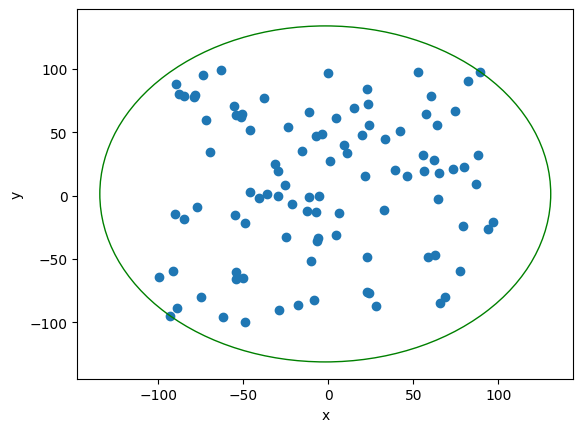

In [ ]:
vis = Visualizer()
vis.add_point(points_a)
vis.add_circle((circle_a.S[0], circle_a.S[1], circle_a.r), color='green', fill = False)
vis.show()

Rezultat działania algorytmu Grahama

In [ ]:
graham_points_a = graham_algorithm(points_a)

Wizualizacja algorytmu Grahama

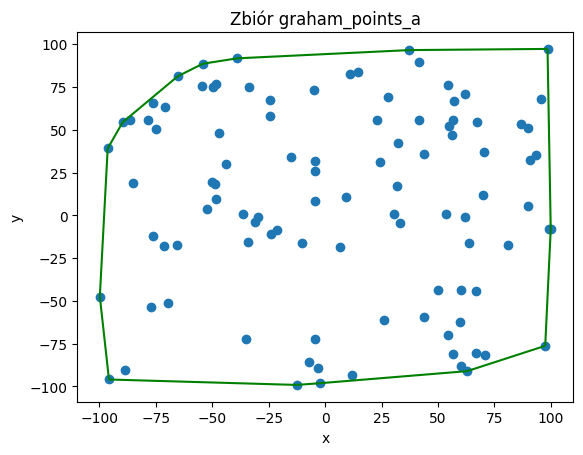

In [ ]:
vis = Visualizer()
vis.add_title('Zbiór graham_points_a')
vis.add_point(points_a)
vis.add_line_segment([(graham_points_a[i], graham_points_a[i+1]) for i in range(len(graham_points_a)-1)], color = 'green')
vis.add_line_segment([graham_points_a[-1], graham_points_a[0]], color = 'green')
vis.show()